In [32]:
import pickle
from sklearn import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

ARRAY_SIZE = 4
NAME = "H1"
SENSOR_LAG = 25

models = []

# Load the models

for i in range(ARRAY_SIZE):
  
  model_F_x = pickle.load(open(f'models/{NAME}_sensor{i}/F_x', 'rb'))
  model_F_y = pickle.load(open(f'models/{NAME}_sensor{i}/F_y', 'rb'))
  model_F_z = pickle.load(open(f'models/{NAME}_sensor{i}/F_z', 'rb'))
  
  models.append([model_F_x, model_F_y, model_F_z])


In [65]:
import os

# Load sensor data file including silicone
TF_file = '../scripts/FT300-S_force_torque/data/H1_2x2_sil50_2mm_20231116_172017.csv'
sensor_file = '../scripts/2x2_sensor/data/H1_2x2_sil50_2mm_20231116_172016.csv'

TFdata = pd.read_csv(os.path.join(os.getcwd(), TF_file))
sensordata = pd.read_csv(os.path.join(os.getcwd(), sensor_file))

for col in TFdata.columns:
  TFdata[col .split(' ')[0]] = TFdata[col]
  
for col in sensordata.columns:
  sensordata[col .split(' ')[0]] = sensordata[col]
  
print(sensordata.info())
print(TFdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3247 entries, 0 to 3246
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   t_wall [s]  3247 non-null   float64
 1   X0 [uT]     3247 non-null   float64
 2   Y0 [uT]     3247 non-null   float64
 3   Z0 [uT]     3247 non-null   float64
 4   X1 [uT]     3247 non-null   float64
 5   Y1 [uT]     3247 non-null   float64
 6   Z1 [uT]     3247 non-null   float64
 7   X2 [uT]     3247 non-null   float64
 8   Y2 [uT]     3247 non-null   float64
 9   Z2 [uT]     3247 non-null   float64
 10  X3 [uT]     3247 non-null   float64
 11  Y3 [uT]     3247 non-null   float64
 12  Z3 [uT]     3247 non-null   float64
 13  t_wall      3247 non-null   float64
 14  X0          3247 non-null   float64
 15  Y0          3247 non-null   float64
 16  Z0          3247 non-null   float64
 17  X1          3247 non-null   float64
 18  Y1          3247 non-null   float64
 19  Z1          3247 non-null  

In [66]:
# Preprocessing
sensordata['t_wall'] -= SENSOR_LAG/1000

sensor_is_first = sensordata['t_wall'][0] < TFdata['t_wall'][0]
sensor_is_last = sensordata['t_wall'][len(sensordata)-1] > TFdata['t_wall'][len(TFdata)-1]

if sensor_is_first:
  start = TFdata['t_wall'][0]
else:
  start = sensordata['t_wall'][0]
  
if sensor_is_last:
  end = sensordata['t_wall'][len(sensordata)-1]
else:
  end = TFdata['t_wall'][len(TFdata)-1]
  
# Clip data to start at the same time and also to end at the same time
TFdata = TFdata[TFdata['t_wall'] >= start]
sensordata = sensordata[sensordata['t_wall'] >= start]
TFdata = TFdata[TFdata['t_wall'] <= end]
sensordata = sensordata[sensordata['t_wall'] <= end]

is_sensor_faster = len(sensordata) > len(TFdata)

combined = pd.concat([sensordata, TFdata], ignore_index=True, sort=False).sort_values(by=['t_wall'])

combined.set_index('t_wall')
combined = combined.apply(lambda x: x.interpolate(method='linear')).reset_index()

for i in range(ARRAY_SIZE):
  for letter in [f'X{i}', f'Y{i}', f'Z{i}']:
    combined[letter] -= np.mean(combined[letter][:100])
    combined[letter] /= 1000

In [67]:
for i in range(ARRAY_SIZE):
  combined[f'sens{i}_magnitude'] = np.sqrt(combined[f'X{i}']**2 + combined[f'Y{i}']**2 + combined[f'Z{i}']**2)
  combined[f'sens{i}_magnitude_XY'] = np.sqrt(combined[f'X{i}']**2 + combined[f'Y{i}']**2)

In [68]:
# Predict forces
for i in range(ARRAY_SIZE):
  for j, letter in enumerate(['x', 'y', 'z']):
    combined[f'F_{letter}{i}'] = models[i][j].predict(combined[[f'X{i}', f'Y{i}', f'Z{i}', f'sens{i}_magnitude', f'sens{i}_magnitude_XY']])


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/bas

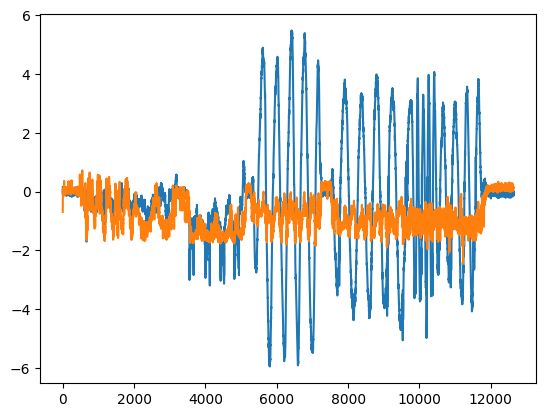

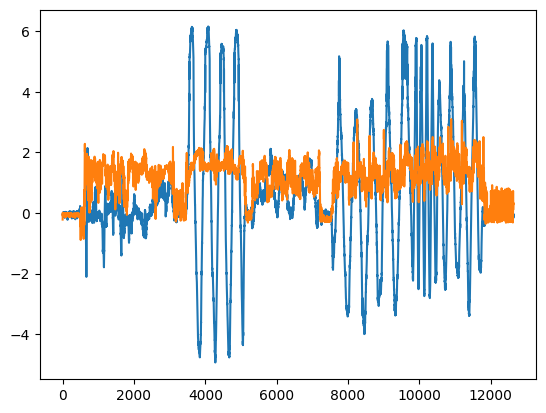

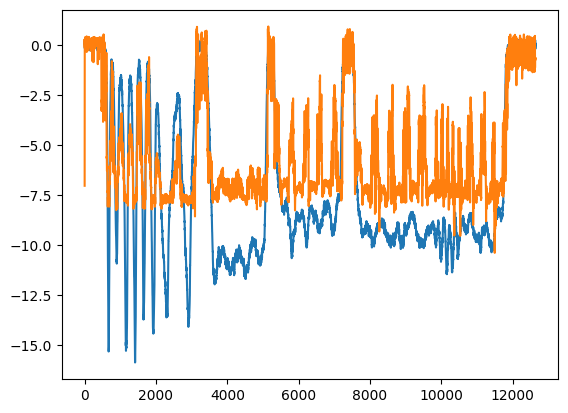

In [69]:
for letter in ['x', 'y', 'z']:
  plt.plot(combined[f'F_{letter}'])
  plt.plot(combined[f'F_{letter}0'] + combined[f'F_{letter}1'] + combined[f'F_{letter}2'] + combined[f'F_{letter}3'])
  # plt.xlim(7000, 9000)
  plt.show()
  

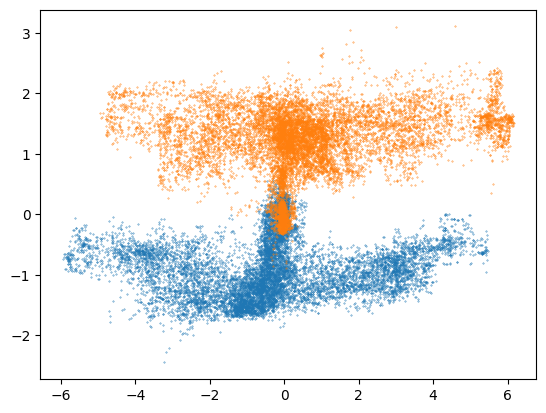

In [70]:
plt.scatter(combined['F_x'], combined['F_x0'] + combined['F_x1'] + combined['F_x2'] + combined['F_x3'], 0.1)
plt.scatter(combined['F_y'], combined['F_y0'] + combined['F_y1'] + combined['F_y2'] + combined['F_y3'], 0.1)

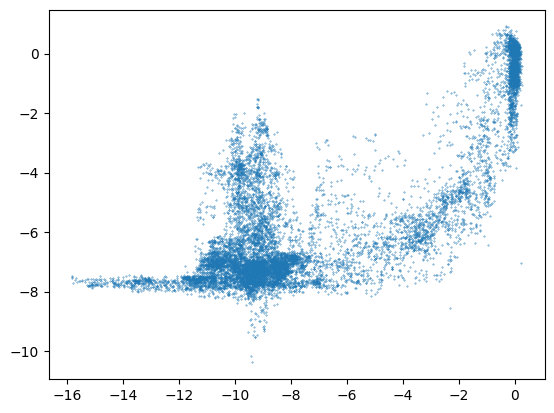

In [71]:
plt.scatter(combined['F_z'], combined['F_z0'] + combined['F_z1'] + combined['F_z2'] + combined['F_z3'], 0.1)

In [64]:
combined.to_csv('combined2.csv')